## General Description

### Intercomparison of 3D Radiation Codes (I3RC): https://i3rc.gsfc.nasa.gov/
----

I3RC is an ongoing project initiated in the late 1990s. Its goals include: 
- Comparing methods available for 3D atmospheric radiative transfer calculations.
- Providing benchmark results for testing and debugging 3D radiative transfer codes.
- Publishing an open source toolkit (community 3D Monte Carlo code).
- Helping atmospheric science education by creating an archive of illustrative images and other resources on 3D radiative transfer.

Benchmark test-cases are devided into three phases. This notebook implements them for the mitsuba-renderer (https://www.mitsuba-renderer.org/), comparing it to gold-standard atmospheric science codes.

---
##### Phase I
Includes several baseline radiative computations for 3D radiative transfer through the following cloud fields:
1. 1D academic 'step' cloud field
2. 2D field derived from the ARM cloud radar
3. 3D field derived from radiances measured by the Landsat Thematic Mapper instrument

These computations involved cloud and surface only (i.e., no gases or aerosol) and were monochromatic, with scattering and absorption only (i.e., no emission), and were completed independently at each participants' home institutions.

---
#### Outputs

Mean and higher order moments of: 
   1. albedo (R)
   2. transmittance (T)
   3. absorptance (wherever applicable) (A)
   4. net horizontal flux (H) defined as $1-R-T-A$
   5. nadir reflectivity (Iu) defined as $\pi\nu / (F \mu_0)$ where: 
       - $\nu$ - upward exiting radiance at 0 degrees
       - $\mu_0$ - cosine of the solar zenith angle
       - $F=1$ is the incident solar flux
   6. oblique reflectivities (Io) defined as $\pi N_o / (F\mu_0)$ where:
       - $N_o$ - upward exiting radiance at 60 degrees zenith and 0 and 180 degrees azimuth angles (i.e. two oblique reflectivities are requested)
   7. zenith transmissivity (Id) defined as $\pi N_d/(F\mu_0)$ where:
       - $N_d$ - downward exiting radiance at 180 degrees (requested only when SZA=60)


Higher order moments are calculated as 
$$ \frac{1}{N}\sum_{i=1}^N (x_i-\bar{x})^k, \quad k=2,6 \quad  N=32$$

---
#### Consensus Results :

http://i3rc.gsfc.nasa.gov/consensus_result/consensus_result_case1.tar

File format: I3RC_cons_res_case1_exp#_RQ.txt 

http://i3rc.gsfc.nasa.gov/input/step_cloud/README.txt

#### Compare mitsuba to I3RC consensus results:
---

     Exp.#    
        1.    SZA = 0,  w0 = 1
        2.    SZA = 60, w0 = 1
        3.    SZA = 0,  w0 = 0.99
        4.    SZA = 60, w0 = 0.99
    
    "RQ" is the radiative quantity. RQ takes the following values:
        - RQ=R     (reflectance)
        - RQ=T     (transmittance)
        - RQ=A     (absorptance)
        - RQ=H     (net horizontal flux)
        - RQ=Iu    (nadir reflectivity)
        - RQ=I601  (reflectivity at 60 view, 0 azimuth)
        - RQ=I602  (reflectivity at 60 view, 180 azimuth)
        - RQ=Id    (zenith transmissivity) 

## Intialization Cells

In [1]:
" Load imports requiered for this notebook "
import i3rc

# Mitsuba imports
from mitsuba.core import *
from mitsuba.render import Scene, RenderQueue, RenderJob

# Other imports 
import numpy as np
import matplotlib.pyplot as plt
import os, sys 
from tqdm import tqdm
import multiprocessing

scheduler = Scheduler.getInstance()
ncores = multiprocessing.cpu_count()

# Start up the scheduling system with one worker per local core
for i in range(0, ncores): 
    scheduler.registerWorker(LocalWorker(i, 'wrk%i' % i))
scheduler.start()

' Load imports requiered for this notebook '

In [2]:
" Initialize functions requiered for this notebook "

def loadI3RC(case, experiments):
    i3rc_results = dict()
    for exp in experiments:
        case.setExperiment(exp)
        i3rc_results[exp] = case.getResults()
    return i3rc_results       

def renderMitsuba(case, experiments, nsamples, ncores=32):
    queue = RenderQueue()
    pmgr = PluginManager.getInstance()
    mts_results = dict()
    for exp in tqdm(experiments):
        case.setExperiment(exp)
        scene = case.getScene(nsamples)
        size = scene.getSensor().getFilm().getSize()
        blocksize = max(np.divide(max(size.x, size.y), ncores), 1) # For speed 
        scene.setBlockSize(blocksize) 
        bitmap = Bitmap(Bitmap.ELuminance, Bitmap.EFloat32, size)
        job = RenderJob('myRenderJob', scene, queue)
        job.start()
        queue.waitLeft(0)

        # Develop the camera's film and import i3rc consensus result
        scene.getFilm().develop(Point2i(0, 0), size, Point2i(0, 0), bitmap);
        mts_results[exp] = np.array(bitmap.buffer()) * case.radiance2BRF
    return mts_results
    
    
def plot_compareResults1D(experiments, mts_results, i3rc_results):
    numRows = np.ceil(len(experiments)/3.0).astype(np.int)
    numCols = min(3,len(experiments))
    f, axarr = plt.subplots(numRows, numCols, figsize=(13, 5*numRows));
    if isinstance(axarr, np.ndarray):
        axarr = axarr.ravel()
    else:
        axarr = [axarr]
    for ax, exp in zip(axarr, experiments):
        ax.plot(mts_results[exp].T, label='Mitsuba');
        ax.plot(i3rc_results[exp], label='I3RC Consensus');
        ax.legend(fontsize=12, loc='best');
        ax.set_title('{}'.format(exp), fontsize=14, y=1.03); 
        ax.set_xlabel('x [km]', fontsize=12);
    plt.subplots_adjust(hspace=0.3);
    
def plot_compareResults2D(experiments, mts_results, i3rc_results):
    numRows = len(experiments)
    numCols = 3
    f, axarr = plt.subplots(numRows, numCols, figsize=(13, 5*numRows), sharey=True);
    if axarr.ndim==1:
        axarr = axarr[None]
    img = [None]*3
    for ax, exp in zip(axarr, experiments):
        img[0] = ax[0].imshow(mts_results[exp]);
        ax[0].set_title('Mitsuba', fontsize=14, y=1.03)
        ax[0].set_xlabel('x [km]', fontsize=12);
        ax[0].set_ylabel('y [km]', fontsize=12);
        img[1] = ax[1].imshow(i3rc_results[exp]);
        ax[1].set_title('I3RC Consensus', fontsize=14, y=1.03)
        ax[1].set_xlabel('x [km]', fontsize=12);
        ax[1].set_ylabel('y [km]', fontsize=12);
        img[2] = ax[2].imshow(np.abs(i3rc_results[exp]-mts_results[exp]))
        ax[2].set_title('diff = |i3rc - mts|', fontsize=14, y=1.03)
        for i,colax in enumerate(ax):
            colax.set_xlabel('x [km]', fontsize=12);
            colax.set_ylabel('y [km]', fontsize=12);
            plt.colorbar(img[i], ax=colax)

' Initialize functions requiered for this notebook '

## Phase I

### 1D academic step cloud field

#### Scenario 

- X-direction: $32$ columns (pixels): 16 have an optical depth of $\tau=2$. The remaining have $\tau=18$. Total size is 0.5km, thus $dx=0.5/32~ {\rm km}$.
- Y-direction: infinite.
- Z-direction: Geometrical thickness is set to 0.25 km everywhere (flat cloud).
   
  - Project page: https://i3rc.gsfc.nasa.gov/input/step_cloud/index.html
  - Readme: https://i3rc.gsfc.nasa.gov/input/step_cloud/README.txt
  - Result file: http://i3rc.gsfc.nasa.gov/consensus_result/consensus_result_case1.tar    

#### Experiments

ASSUMPTIONS:
1. No atmospheric effects
2. Periodic boundary conditions (cloud field is repeated an infinite
   number of times along the x direction)
3. Henyey-Greenstein phase function (PF) with g=0.85
4. Black (zero reflectance) surface
5. Single scattering albedos w0=1 and w0=0.99 (with the same PF
   and extinction field).

SOLAR GEOMETRY: 
1. Sun at (SZA of) zero degrees
2. Sun at 60 degrees and 0 azimuth (Sun shining from low x coordinates)

#### Code

100%|██████████| 6/6 [00:42<00:00,  7.15s/it]


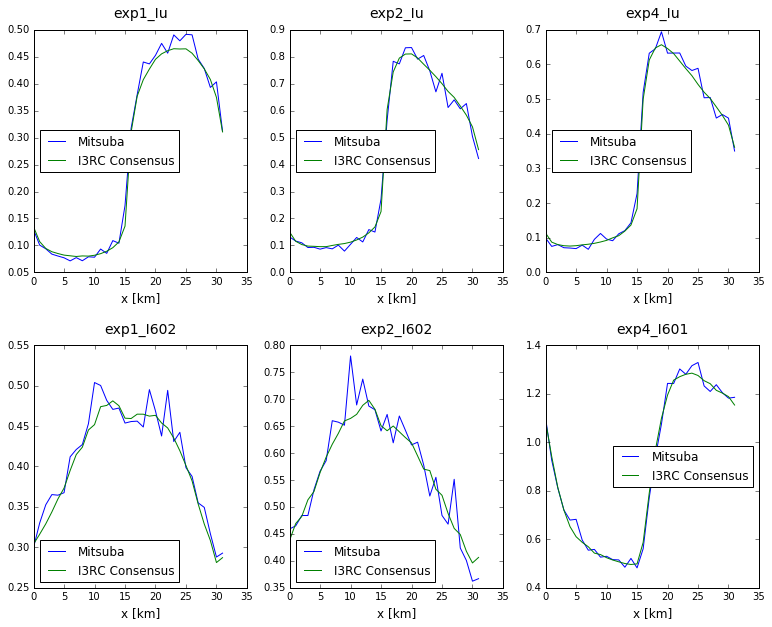

In [3]:
case = i3rc.Case1()
experiments = ['exp1_Iu', 'exp2_Iu', 'exp4_Iu', 'exp1_I602', 'exp2_I602', 'exp4_I601']

mitsuba_results = renderMitsuba(case, experiments, nsamples=16384, ncores=ncores)
i3rc_results = loadI3RC(case, experiments)

%matplotlib inline 
plot_compareResults1D(experiments, mitsuba_results, i3rc_results)

### 2D field derived from the ARM cloud radar

The 2D cloud field for this experiment is based on extinction retrievals from the MMCR (Millimiter Cloud Radar) and the MWR (microwave radiometer)at the ARM CART site in Lamont, OK on Feb. 8, 98. 

#### Scenario 

- X-direction: 640 columns (pixels) each of size dx=50m: total width is 32km.
- Y-direction: Infinite.
- Z-direction: 54 vertical layers each of size dz=45m: total vertical size is 2.43km. 

  - Project page: https://i3rc.gsfc.nasa.gov/input/MMCR/high_res/020898/index.html
  - Readme: https://i3rc.gsfc.nasa.gov/input/MMCR/high_res/020898/README.txt
  - Result file http://i3rc.gsfc.nasa.gov/consensus_result/consensus_result_case2.tar    

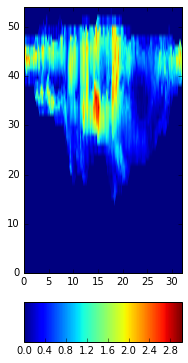

In [20]:
" Plot the 2D extinxtion field "

from mpl_toolkits.axes_grid1 import make_axes_locatable
from operator import itemgetter

%matplotlib inline
case = i3rc.Case2()
data, boundingBox = case.volumetricData.getData()
data = data[:,0,:].reshape(data.shape[0],data.shape[-1]).T
plt.figure(figsize=(6,6));
img = plt.imshow(data, extent=itemgetter(0,3,2,5)(boundingBox)); 
ax = plt.gca()
divider = make_axes_locatable(ax);
cax = divider.append_axes("bottom", size="15%", pad=0.4);
plt.colorbar(img, cax=cax, orientation='horizontal');

#### Experiments

ASSUMPTIONS:
1. No atmospheric effects
2. Periodic boundary conditions (cloud field is repeated an infinite
   number of times along the x direction)
3. Henyey-Greenstein phase function (PF) with g=0.85 and C.1
   (Dermeindjian 1969)
4. Black (zero reflectance) surface
5. Single scattering albedos w0=1 and w0=0.99 (with the same PF
   and extinction field).

SOLAR GEOMETRY: 
1. Sun at (SZA of) zero degrees
2. Sun at 60 degrees and 0 azimuth (Sun shining from low x coordinates)

#### Code

100%|██████████| 1/1 [02:45<00:00, 165.25s/it]


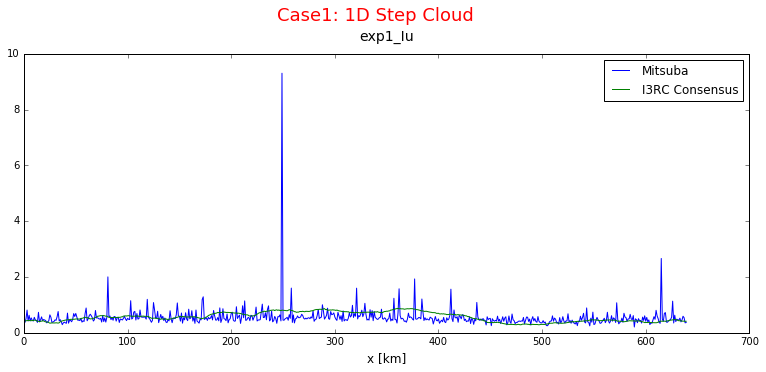

In [7]:
case = i3rc.Case2()
experiments = ['exp1_Iu']

mitsuba_results = renderMitsuba(case, experiments, nsamples=512, ncores=ncores)
i3rc_results = loadI3RC(case, experiments)

%matplotlib inline 
plot_compareResults1D(experiments, mitsuba_results, i3rc_results)

### 3D Landsat cloud case

The 2D cloud field for this experiment is from an Independent Approximation retrieval on a 128x128 segment of a Landsat-4 scene used in Oreopoulos and Davies, J. Climate, 11, 919-932, 1998. Band 4 (0.83 microns) was used.

#### Scenario 

- X-direction: 128 columns(pixels) each of size dx=30: total width is 3.84km.
- Y-direction: 128 columns(pixels) each of size dx=30: total width is 3.84km.
- Z-direction: Homogeneous colums with optical and geometrical depth according to files. Cloud bottom at 0.2km and cloud top determined from the geometrical thickness.

  - Project page: https://i3rc.gsfc.nasa.gov/input/Landsat/index.html
  - Readme: https://i3rc.gsfc.nasa.gov/input/Landsat/README.txt
  - Result file http://i3rc.gsfc.nasa.gov/consensus_result/consensus_result_case2.tar    

#### Experiments

ASSUMPTIONS:
1. No atmospheric effects
2. Periodic boundary conditions (cloud field is repeated an infinite
   number of times along the x and y directions)
3. Henyey-Greenstein phase function (PF) with g=0.85.
4. Black (zero reflectance) surface
5. Single scattering albedos w0=1 and w0=0.99 (with the same PF
   and extinction field).

SOLAR GEOMETRY: 
1. Sun at (SZA of) zero degrees
2. Sun at 60 degrees and 0 azimuth (Sun shining from low x coordinates)

#### code

100%|██████████| 1/1 [12:19<00:00, 739.68s/it]


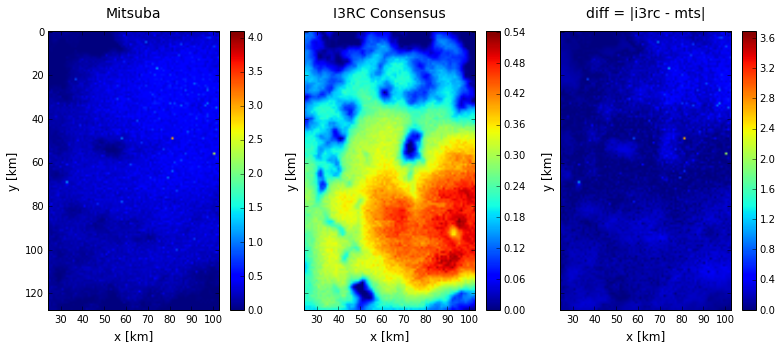

In [4]:
case = i3rc.Case3()
experiments = ['exp1_Iu']
mitsuba_results = renderMitsuba(case, experiments, nsamples=1024, ncores=ncores)
i3rc_results = loadI3RC(case, experiments)

%matplotlib inline 
plot_compareResults2D(experiments, mitsuba_results, i3rc_results)